In [1]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_idx = 50

In [3]:
image_params = {
                'N_PIXELS': 128,
                'PIXEL_SIZE': 2.08,
                'SIGMA': 4.0,
                'ROTATIONS': True,
                'SHIFT': True,
                'CTF': True,
                'NOISE': True,
                'DEFOCUS': 2.0,
                'SNR': 0.1,
                'RADIUS_MASK': 64,
                'AMP': 0.1,
                'B_FACTOR': 1,
                'ELECWAVE': 0.019866
}

In [4]:
coord = np.load("../data/protein_models/6wxb_models.npy")[model_idx]

## Rotate structure

In [5]:
quat = np.array([-0.76882173,  0.21902341, -0.3074588 ,  0.51615015])
rot_mat = Rotation.from_quat(quat).as_matrix()
coord = np.matmul(rot_mat, coord)

## Generating the projection

In [6]:
def gen_img(coord, image_params):

    n_atoms = coord.shape[1]
    norm = 1 / (2 * torch.pi * image_params["SIGMA"] ** 2 * n_atoms)

    grid_min = -image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
    grid_max = (
        image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
        + image_params["PIXEL_SIZE"]
    )

    grid = torch.arange(grid_min, grid_max, image_params["PIXEL_SIZE"])

    gauss_x = torch.exp(
        -0.5 * (((grid[:, None] - coord[0, :]) / image_params["SIGMA"]) ** 2)
    )

    gauss_y = torch.exp(
        -0.5 * (((grid[:, None] - coord[1, :]) / image_params["SIGMA"]) ** 2)
    )

    image = torch.matmul(gauss_x, gauss_y.T) * norm

    return image

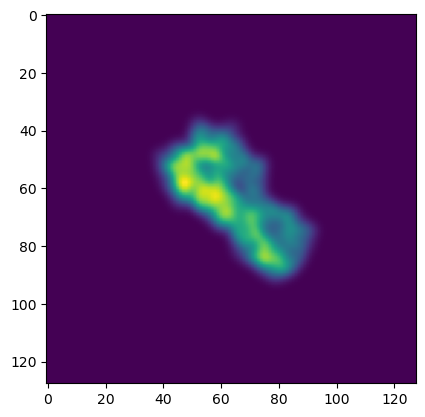

In [7]:
image = gen_img(coord, image_params)
plt.imshow(image)

## Add padding for shift

In [8]:
from torch.nn import ConstantPad2d
def pad_image(image, image_params):

    pad_width = int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1
    
    padder = ConstantPad2d(pad_width, 0.0)

    padded_image = padder(image)

    return padded_image

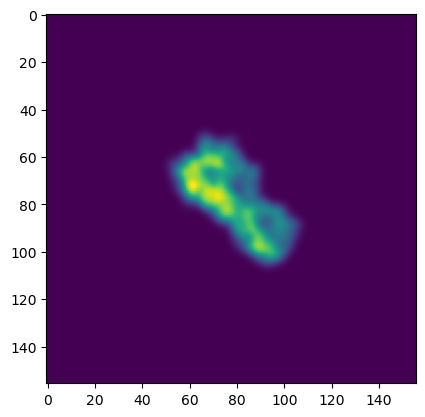

In [9]:
image_clear = pad_image(image, image_params)
plt.imshow(image_clear)

## Calculate and add the ctf

In [10]:
def calc_ctf(image_params):

    # Attention look into def pad_image function to know the image size after padding 
    image_size = 2 * ( int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1) + image_params["N_PIXELS"]

    freq_pix_1d = torch.fft.fftfreq(
        image_size,
        d=image_params["PIXEL_SIZE"]
    )

    if isinstance(image_params["DEFOCUS"], float):
        phase = image_params["DEFOCUS"] * np.pi * 2.0 * 10000 * image_params["ELECWAVE"]

    elif isinstance(image_params["DEFOCUS"], list) and len(image_params["DEFOCUS"]) == 2:
        defocus = np.random.uniform(low=image_params["DEFOCUS"][0], high=image_params["DEFOCUS"][1])
        phase = defocus * np.pi * 2.0 * 10000 * image_params["ELECWAVE"]

    else:
        raise ValueError("Defocus should be a single value or a list of [min_defocus, max_defocus]")

    x, y = torch.meshgrid(freq_pix_1d, freq_pix_1d)

    freq2_2d = x**2 + y**2
    imag = torch.zeros_like(freq2_2d) * 1j

    env = torch.exp(torch.tensor(-image_params["B_FACTOR"] * freq2_2d * 0.5))
    ctf = (
        image_params["AMP"] * torch.tensor(phase * freq2_2d * 0.5).cos()
        - torch.tensor(1 - image_params["AMP"]**2).sqrt()
        * torch.tensor(phase * freq2_2d * 0.5).sin()
        + imag
    )
    return ctf * env / image_params["AMP"]


def apply_ctf(image, ctf):

    conv_image_ctf = torch.fft.fft2(image) * ctf

    image_ctf = torch.fft.ifft2(conv_image_ctf).real

    return image_ctf

/home/dingeldein/anaconda3/envs/cryo_sbi/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/tmp/ipykernel_3690722/2022353910.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  env = torch.exp(torch.tensor(-image_params["B_FACTOR"] * freq2_2d * 0.5))
/tmp/ipykernel_3690722/2022353910.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_params["AMP"] * torch.tensor(phase * freq2_2d * 0.5).cos()
/tmp/ipykernel_3690722/2022353910.py:30:

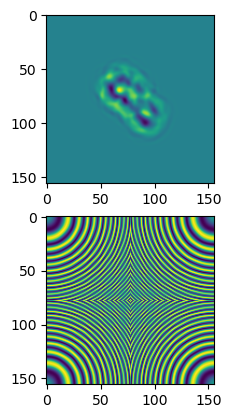

In [11]:
ctf = calc_ctf(image_params)
image_ctf = apply_ctf(image_clear, calc_ctf(image_params))
plt.subplot(211)
plt.imshow(image_ctf)
plt.subplot(212)
plt.imshow(ctf.real)

## Add noise

In [12]:
def circular_mask(n_pixels, radius):

    grid = torch.linspace(-0.5 * (n_pixels - 1), 0.5 * (n_pixels - 1), n_pixels)
    r_2d = grid[None, :]**2 + grid[:, None]**2
    mask = r_2d < radius**2

    return mask


def add_noise(img, image_params):

    mask = circular_mask(n_pixels=img.shape[0], radius=image_params["RADIUS_MASK"])

    signal_std = img[mask].pow(2).mean().sqrt()

    if isinstance(image_params["SNR"], float):
        snr = image_params["SNR"]

    elif isinstance(image_params["SNR"], list) and len(image_params["SNR"]) == 2:
        snr = np.random.uniform(low=image_params["SNR"][0], high=image_params["SNR"][1])

    else:
        raise ValueError("SNR should be a single value or a list of [min_defocus, max_defocus]")

    noise_std = signal_std / np.sqrt(snr)

    img_noise = img + torch.distributions.normal.Normal(0, noise_std).sample(img.shape)

    return img_noise


def add_gradient_noise(img, image_params):

    mask = circular_mask(n_pixels=img.shape[0], radius=image_params["RADIUS_MASK"])

    signal_std = img[mask].pow(2).mean().sqrt()
    noise_std = signal_std / np.sqrt(image_params["SNR"])
    
    noise = torch.stack(
        [
            torch.distributions.normal.Normal(0, signal_std / np.sqrt(snr)).sample([img.shape[0],]) 
            for snr in np.logspace(-1, -2, img.shape[0])
        ],
        dim=1
    )
    
    img_noise = img + noise

    return img_noise


def add_shot_noise(clear_image, image_params):

    norm_img = clear_image.abs() / clear_image.abs().max()
    shot_noise = torch.poisson(norm_img * 0.05)
    
    shot_image = clear_image * (shot_noise + 1)
    print(shot_noise.sum())
    ctf_image = apply_ctf(shot_image, calc_ctf(image_params))

    img = add_noise(ctf_image, image_params)

    return img


def add_colored_noise(img, image_params):
    image_L = img.shape[0]

    mask = circular_mask(n_pixels=img.shape[0], radius=image_params["RADIUS_MASK"])

    signal_std = img[mask].pow(2).mean().sqrt()
    noise_std = signal_std / np.sqrt(image_params["SNR"])
    
    img_noise = torch.distributions.normal.Normal(0, noise_std).sample(img.shape)
    fft_noise = torch.fft.fft2(img_noise)

    noise_scale = 1.5
    along_x, along_y = np.linspace(-1, 1, image_L), np.linspace(-1, 1, image_L)
    mesh_x, mesh_y = np.meshgrid(along_x, along_y)
    f = torch.zeros((image_L, image_L))

    for ix in range(image_L):
        for iy in range(image_L):
            f[ix, iy] = np.abs(mesh_x[ix, iy])**noise_scale + np.abs(mesh_y[ix, iy])**noise_scale

    t = torch.abs(torch.fft.ifft2(fft_noise / f))

    noise_scale = 1.0 / (t.max() - t.median())
    t = ((t - t.median()) * noise_scale) + 1

    img_noise = torch.distributions.normal.Normal(0, noise_std * t).sample()
    return img_noise + img

In [ ]:
image = add_noise(image_ctf, image_params)

In [ ]:
image = add_colored_noise(image_ctf, image_params)

In [13]:
image_0 = add_shot_noise(image, image_params)

tensor(35., dtype=torch.float64)


/tmp/ipykernel_3690722/2022353910.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  env = torch.exp(torch.tensor(-image_params["B_FACTOR"] * freq2_2d * 0.5))
/tmp/ipykernel_3690722/2022353910.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_params["AMP"] * torch.tensor(phase * freq2_2d * 0.5).cos()
/tmp/ipykernel_3690722/2022353910.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(phase * freq2_2d * 0.5).sin()


RuntimeError: The size of tensor a (128) must match the size of tensor b (156) at non-singleton dimension 1

In [ ]:
plt.imshow(add_colored_noise(image, image_params))

In [ ]:
add_shot_noise(image, image_params).max()

In [ ]:
plt.imshow(add_shot_noise(image_clear, image_params))

## Add random shift

In [ ]:
def apply_random_shift(padded_image, image_params):

    shift_x = int(torch.ceil(image_params["N_PIXELS"] * 0.1 * (2 * torch.rand(1) - 1)))
    shift_y = int(torch.ceil(image_params["N_PIXELS"] * 0.1 * (2 * torch.rand(1) - 1)))

    pad_width = int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1

    low_ind_x = pad_width - shift_x
    high_ind_x = padded_image.shape[0] - pad_width - shift_x

    low_ind_y = pad_width - shift_y
    high_ind_y = padded_image.shape[0] - pad_width - shift_y

    shifted_image = padded_image[low_ind_x:high_ind_x, low_ind_y:high_ind_y]

    return shifted_image


def apply_no_shift(padded_image, image_params):

    pad_width = int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1

    low_ind_x = pad_width
    high_ind_x = padded_image.shape[0] - pad_width

    low_ind_y = pad_width
    high_ind_y = padded_image.shape[0] - pad_width

    shifted_image = padded_image[low_ind_x:high_ind_x, low_ind_y:high_ind_y]

    return shifted_image

In [ ]:
image = apply_random_shift(image, image_params)
plt.imshow(image)

## Normalize image

In [ ]:
def gaussian_normalize_image(image):

    mean_img = torch.mean(image)
    std_img = torch.std(image)

    return (image - mean_img) / std_img

image = gaussian_normalize_image(image).to(dtype=torch.float)

In [ ]:
plt.imshow(image, vmax=4, vmin=-4, cmap='gray')

## Write particle to BioEM readble format

In [ ]:
#with open(f'particle_from_{model_idx}_snr1', 'a') as f:
#    f.writelines('PARTICLE 1\n')
#    for i in range(64):
#        for j in range(64):
#            f.writelines('%8d%8d%16.8f\n' %(i, j, image[i, j]))